<a href="https://colab.research.google.com/github/KGuruPrasad94/Craft_demo/blob/main/Craft_demo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Craft Demo - Intro

Goal: Optimize its policies and rules to accurately identify risky batches while minimizing user friction.

# **1. Import and Setup**

In [1]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import scipy as sp
import os
import random
import requests
import zipfile
import io
from datetime import timedelta

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# setting display settings to view full df
pd.set_option('display.max_columns', None)

# **2. Data Load and Exploration**

In [2]:
# load data from github
merchants_url = "https://raw.githubusercontent.com/KGuruPrasad94/Craft_demo/main/Merchant_application_data.csv"
transaction_url = "https://raw.githubusercontent.com/KGuruPrasad94/Craft_demo/main/Merchant_batch_performance_data.csv"

merchants_response = requests.get(merchants_url)
transaction_response = requests.get(transaction_url)

merchants_df = pd.read_csv(io.StringIO(merchants_response.text))
transaction_df = pd.read_csv(io.StringIO(transaction_response.text))

## 2.1 Inspecting Merchant Applications DF

In [3]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,3/5/2018
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,3/23/2016
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,6/20/2017
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,9/28/2016
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,12/3/2017


In [4]:
# inspecting shape of merchants_df
print("Dataset Dimensions: {} x {}".format(merchants_df.shape[0], merchants_df.shape[1]))

Dataset Dimensions: 15426 x 10


In [5]:
# view dataframe info
merchants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15426 entries, 0 to 15425
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SimuID            15426 non-null  int64  
 1   MCC               15426 non-null  int64  
 2   MCCDescription    15426 non-null  object 
 3   Product           15426 non-null  object 
 4   SBG_HVC           15426 non-null  int64  
 5   AppVantageScr     15266 non-null  float64
 6   AppPublicRecords  15158 non-null  float64
 7   AppCollections    15266 non-null  float64
 8   AppAmountPastDue  15158 non-null  float64
 9   AccountOpenDate   15426 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 1.2+ MB


In [6]:
# generate descriptive statistics
merchants_df[['SBG_HVC','AppVantageScr','AppPublicRecords','AppCollections','AppAmountPastDue']].describe(include='all').T
#merchants_df[['SBG_HVC','AppVantageScr','AppPublicRecords','AppCollections','AppAmountPastDue']].describe().T

,count,mean,std,min,25%,50%,75%,max
SBG_HVC,15426.0,0.179113,0.383459,0.0,0.0,0.0,0.0,1.0
AppVantageScr,15266.0,776.616992,120.005015,0.0,687.0,775.0,865.0,990.0
AppPublicRecords,15158.0,0.173308,0.735248,0.0,0.0,0.0,0.0,19.0
AppCollections,15266.0,6.455850,269.520540,0.0,0.0,0.0,0.0,26634.0
AppAmountPastDue,15158.0,2084.486014,20613.614275,0.0,0.0,0.0,0.0,2104254.0


In [7]:
#checking for duplicate values
print(f"Number of duplicate records in dataset: {merchants_df.duplicated().sum()}")

Number of duplicate records in dataset: 0


## 2.2 Inspecting Transaction DF

In [8]:
transaction_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date
0,258132,Credit_Card,2.0,698.66,326.560330,237,10.1593,2,NaN,NaN,6/15/2018
1,235650,Credit_Card,1.0,1000.00,2.860286,99999,85.0034,1157,NaN,NaN,5/19/2018
2,241608,ACH,2.0,622.00,0.000000,76,2.3248,6,NaN,NaN,6/11/2018
3,271779,Credit_Card,2.0,500.00,6.754413,6,113.7732,690,NaN,NaN,6/11/2018
4,261441,Credit_Card,1.0,850.00,NaN,8,-1.0000,307,NaN,NaN,5/29/2018


In [9]:
# inspecting shape of transaction_df
print("Dataset Dimensions: {} x {}".format(transaction_df.shape[0], transaction_df.shape[1]))

Dataset Dimensions: 123082 x 11


In [10]:
# view dataframe info
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123082 entries, 0 to 123081
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SimuID              123082 non-null  int64  
 1   PaymentChannel      123082 non-null  object 
 2   SaleCt              122817 non-null  float64
 3   SalesAmt            122817 non-null  float64
 4   deposit_risk_score  102384 non-null  float64
 5   PriorityScrV1       123082 non-null  int64  
 6   FinancialScoreV2    123082 non-null  float64
 7   Age                 123082 non-null  int64  
 8   ChargebackFinalAmt  412 non-null     float64
 9   ACHRtrnAmt          265 non-null     float64
 10  Batch_Clear_Date    123082 non-null  object 
dtypes: float64(6), int64(3), object(2)
memory usage: 10.3+ MB


In [11]:
# generate descriptive statistics
transaction_df.describe(include='all').T
#transaction_df.describe().T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SimuID,123082.0,NaN,NaN,NaN,254672.643335,14300.455927,230006.0,242350.0,254584.0,267047.25,279999.0
PaymentChannel,123082,2,Credit_Card,93611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCt,122817.0,NaN,NaN,NaN,2.405734,6.394433,0.0,1.0,1.0,2.0,575.0
SalesAmt,122817.0,NaN,NaN,NaN,1393.728936,3915.532539,0.0,160.0,425.0,1230.0,350329.95
deposit_risk_score,102384.0,NaN,NaN,NaN,9.861611,92.903764,0.0,0.130725,1.183045,4.530415,10817.554
PriorityScrV1,123082.0,NaN,NaN,NaN,9051.979615,28619.98929,1.0,6.0,15.0,51.0,99999.0
FinancialScoreV2,123082.0,NaN,NaN,NaN,4.294913,21.156054,-1.0,0.4761,0.9393,2.4061,918.8972
Age,123082.0,NaN,NaN,NaN,606.060155,411.44112,-61.0,274.0,519.0,897.0,1619.0
ChargebackFinalAmt,412.0,NaN,NaN,NaN,877.561214,2115.259566,0.0,95.75,250.0,603.4875,19903.1
ACHRtrnAmt,265.0,NaN,NaN,NaN,1127.492792,2144.238474,10.0,180.0,497.23,1050.0,17566.29


In [12]:
#checking for duplicate values
print(f"Number of duplicate records in dataset: {transaction_df.duplicated().sum()}")

Number of duplicate records in dataset: 0


# **3. EDA, Outlier Treatment and Null Handling**

## 3.1 Exploring Merchants df

In [13]:
# Product
merchants_df['Product'].value_counts()

,count
Product,
QBMS for QBO,14607
GoPayment Free,697
GoPayment,122


In [14]:
# AppCollections
merchants_df['AppCollections'].value_counts()

,count
AppCollections,
0.0,12197
1.0,1401
2.0,593
3.0,364
4.0,202
...,...
359.0,1
311.0,1
9472.0,1


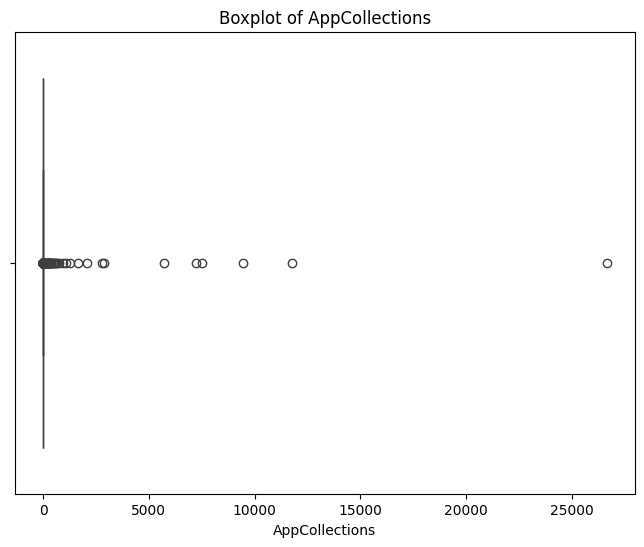

In [15]:
# Create a boxplot for AppAmountPastDue
plt.figure(figsize=(8, 6))
sns.boxplot(x=merchants_df['AppCollections'])
plt.title('Boxplot of AppCollections')
plt.xlabel('AppCollections')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [16]:
# Check values greater than 15000 from AppCollections column
print("Merchants with 'AppCollections' > 15000:")
merchants_df[merchants_df['AppCollections'] > 15000]

Merchants with 'AppCollections' > 15000:


,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
14746,277528,8099,Medical Services and Health Practitioners not ...,QBMS for QBO,0,579.0,0.0,26634.0,0.0,12/4/2016


In [17]:
# removing outlier
merchants_df = merchants_df[merchants_df['AppCollections'] <= 15000]

In [18]:
merchants_df.shape

(15265, 10)

array([[<Axes: title={'center': 'SBG_HVC'}>,
        <Axes: title={'center': 'AppVantageScr'}>],
       [<Axes: title={'center': 'AppPublicRecords'}>, <Axes: >]],
      dtype=object)

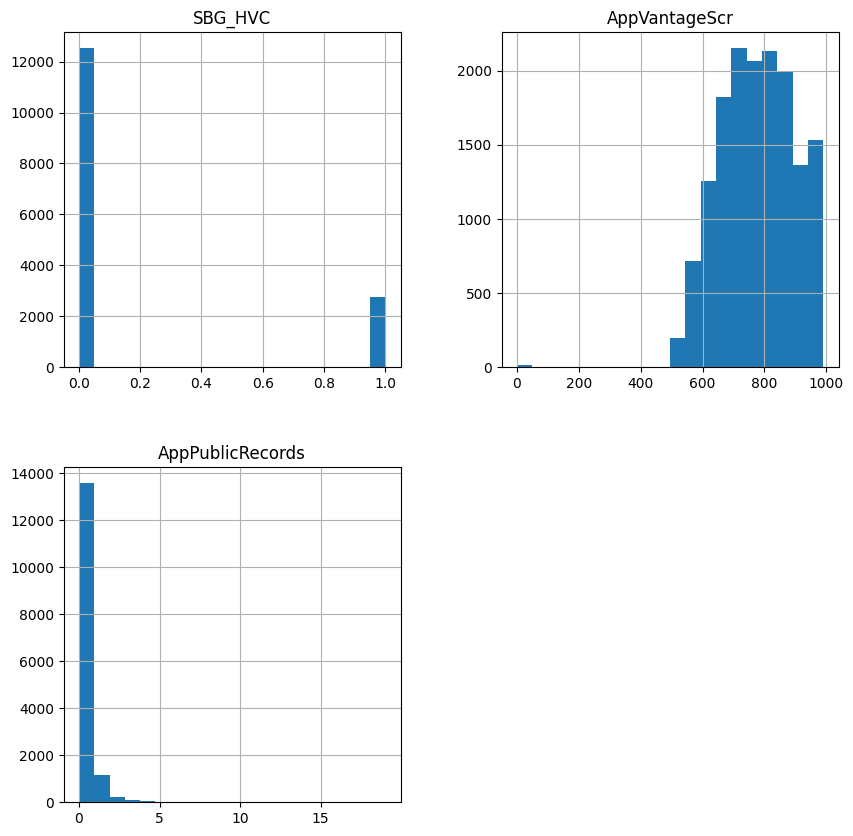

In [19]:
# checking the distribution of merchants_df columns
merchants_df[['SBG_HVC','AppVantageScr','AppPublicRecords']].hist(bins = 20 , figsize= (10,10))

In [20]:
# AppAmountPastDue
merchants_df['AppAmountPastDue'].value_counts()

,count
AppAmountPastDue,
0.0,11807
25.0,14
50.0,12
30.0,8
150.0,7
...,...
1664.0,1
10847.0,1
26855.0,1


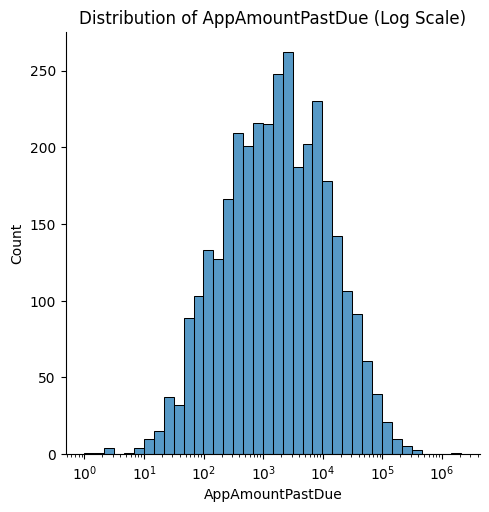

In [21]:
# checking the distribution of "AppAmountPastDue"
sns.displot(merchants_df['AppAmountPastDue'], log_scale=True)
plt.title('Distribution of AppAmountPastDue (Log Scale)')
plt.show()

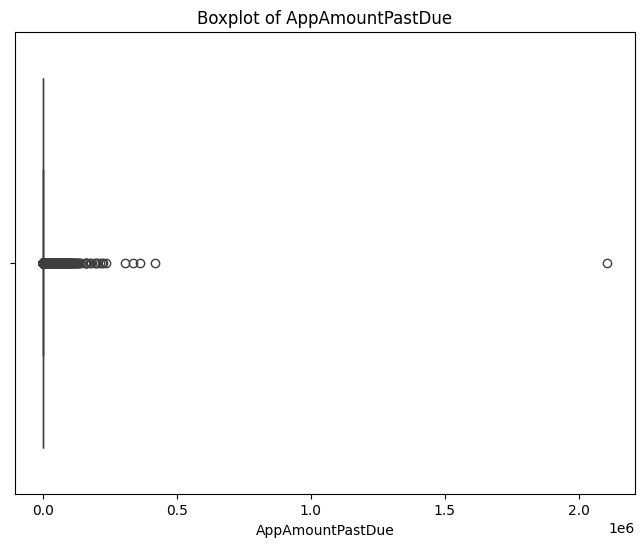

In [22]:
# Create a boxplot for AppAmountPastDue
plt.figure(figsize=(8, 6))
sns.boxplot(x=merchants_df['AppAmountPastDue'])
plt.title('Boxplot of AppAmountPastDue')
plt.xlabel('AppAmountPastDue')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [23]:
# Check values greater than 15000 from AppCollections column
print("Merchants with 'AppCollections' > 500000:")
merchants_df[merchants_df['AppAmountPastDue'] > 500000]

Merchants with 'AppCollections' > 500000:


,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
140,230425,6513,Real Estate Agents and Managers - Rentals,QBMS for QBO,0,911.0,0.0,0.0,2104254.0,3/23/2017


In [24]:
# removing outlier
merchants_df = merchants_df[merchants_df['AppAmountPastDue'] <= 500000]

In [25]:
merchants_df.shape

(15156, 10)

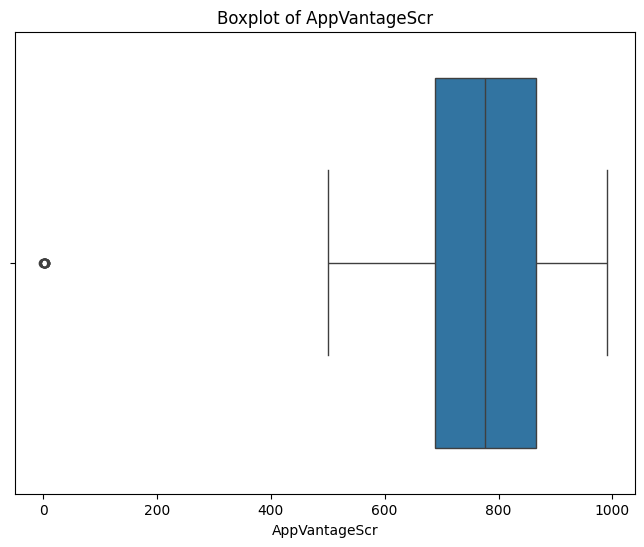

In [26]:
# Create a boxplot for AppVantageScr
plt.figure(figsize=(8, 6))
sns.boxplot(x=merchants_df['AppVantageScr'])
plt.title('Boxplot of AppVantageScr')
plt.xlabel('AppVantageScr')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [27]:
# Check values greater than 15000 from AppCollections column
print("Merchants with 'AppVantageScr' < 400:")
len(merchants_df[merchants_df['AppVantageScr'] < 400])

Merchants with 'AppVantageScr' < 400:


9

In [28]:
# removing outlier
merchants_df = merchants_df[merchants_df['AppVantageScr'] > 400]

In [29]:
merchants_df.shape

(15131, 10)

In [30]:
merchants_df.isnull().sum()

,0
SimuID,0
MCC,0
MCCDescription,0
Product,0
SBG_HVC,0
AppVantageScr,0
AppPublicRecords,0
AppCollections,0
AppAmountPastDue,0
AccountOpenDate,0


## 3.2 Exploring Transaction df

In [31]:
# Define 'is_risky' based on ChargebackFinalAmt or ACHRtrnAmt
transaction_df['is_risky'] = ((transaction_df['ChargebackFinalAmt'].notna()) | (transaction_df['ACHRtrnAmt'].notna())).astype(int)

In [32]:
transaction_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
0,258132,Credit_Card,2.0,698.66,326.560330,237,10.1593,2,NaN,NaN,6/15/2018,0
1,235650,Credit_Card,1.0,1000.00,2.860286,99999,85.0034,1157,NaN,NaN,5/19/2018,0
2,241608,ACH,2.0,622.00,0.000000,76,2.3248,6,NaN,NaN,6/11/2018,0
3,271779,Credit_Card,2.0,500.00,6.754413,6,113.7732,690,NaN,NaN,6/11/2018,0
4,261441,Credit_Card,1.0,850.00,NaN,8,-1.0000,307,NaN,NaN,5/29/2018,0


In [33]:
# Display the count of risky vs non-risky batches
transaction_df['is_risky'].value_counts()

,count
is_risky,
0,122405
1,677


In [34]:
# Group by PaymentChannel and is_risky and count the occurrences
payment_channel_risky_counts = transaction_df.groupby(['PaymentChannel', 'is_risky']).size().reset_index(name='count')

# Display the counts
print("Counts of PaymentChannel by Risky Status:")
display(payment_channel_risky_counts)

Counts of PaymentChannel by Risky Status:


,PaymentChannel,is_risky,count
0,ACH,0,29235
1,ACH,1,236
2,Credit_Card,0,93170
3,Credit_Card,1,441


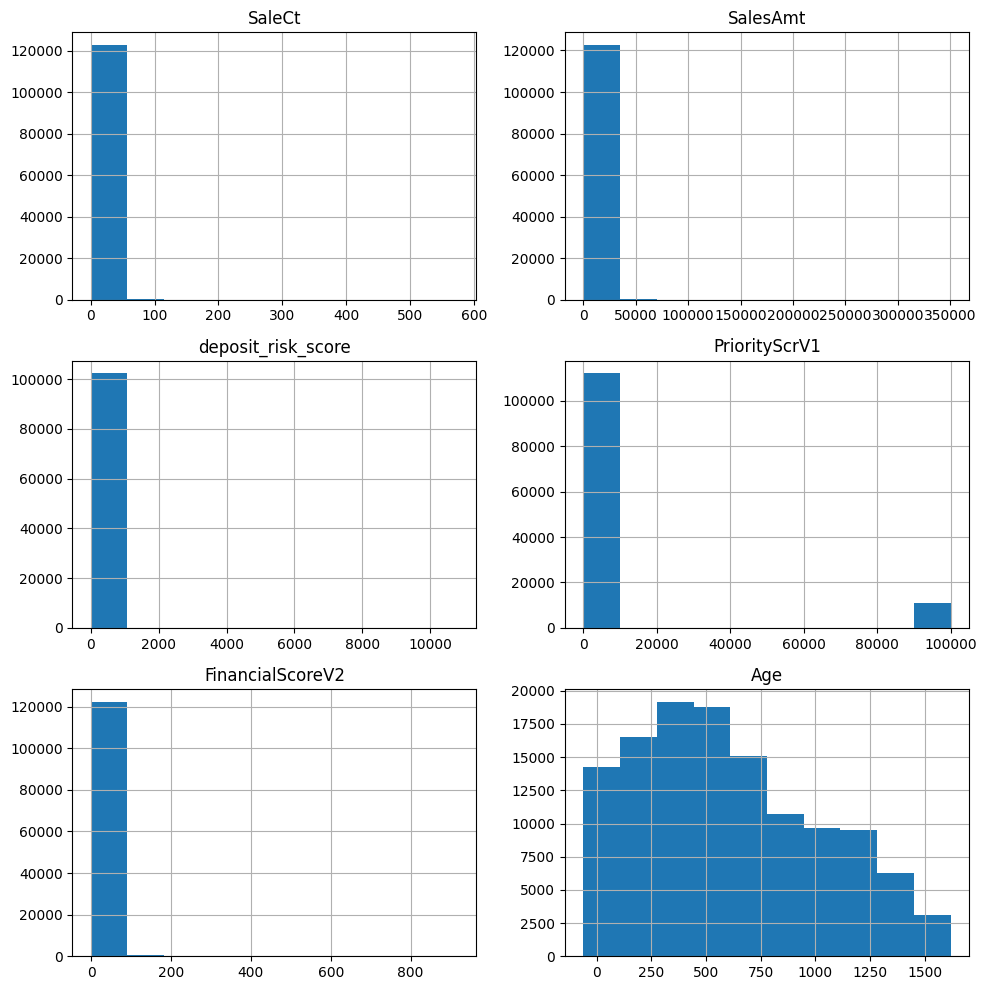

In [35]:
# checking the distribution of transaction_df columns
transaction_df[['SaleCt','SalesAmt','deposit_risk_score','PriorityScrV1','FinancialScoreV2','Age']].hist(bins = 10 , figsize= (10,10))
plt.tight_layout()
plt.show()

In [36]:
# SaleCt
transaction_df['SaleCt'].value_counts()

,count
SaleCt,
1.0,75526
2.0,21791
3.0,9084
4.0,4898
5.0,2991
...,...
211.0,1
274.0,1
281.0,1


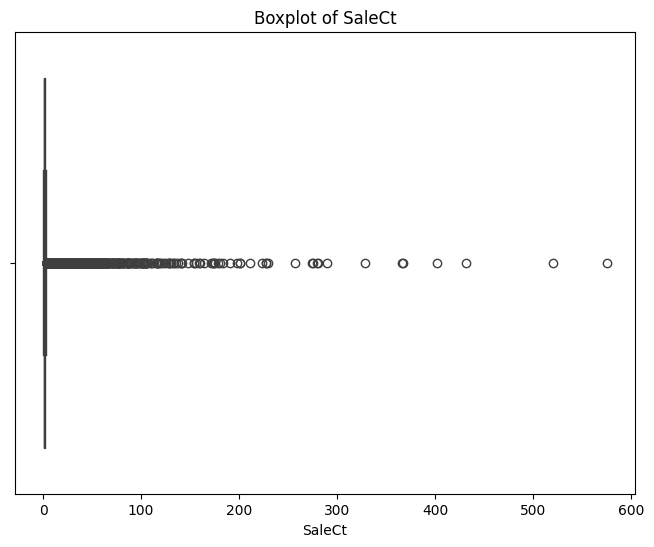

In [37]:
# Create a boxplot for SaleCt
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['SaleCt'])
plt.title('Boxplot of SaleCt')
plt.xlabel('SaleCt')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [38]:
# SaleCt
transaction_df['SalesAmt'].value_counts()

,count
SalesAmt,
100.00,1738
200.00,1429
150.00,1417
300.00,1240
250.00,1203
...,...
1082.51,1
15753.96,1
7008.78,1


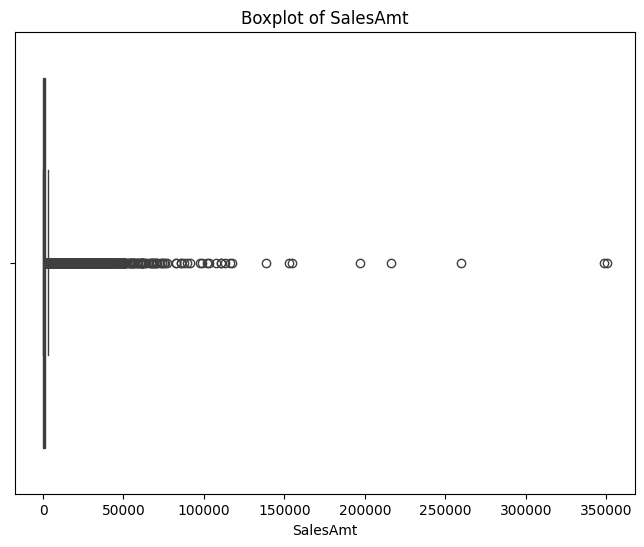

In [39]:
# Create a boxplot for SalesAmt
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['SalesAmt'])
plt.title('Boxplot of SalesAmt')
plt.xlabel('SalesAmt')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [40]:
# Check values greater than 300000 from SalesAmt column
print("Merchants with 'SalesAmt' > 300000:")
transaction_df[transaction_df['SalesAmt'] > 300000]

Merchants with 'SalesAmt' > 300000:


,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
24049,256034,ACH,13.0,348812.40,76.851786,2118,1.2641,1412,NaN,NaN,5/23/2018,0
92840,276388,Credit_Card,520.0,350329.95,NaN,5423,9.2369,305,NaN,NaN,6/1/2018,0


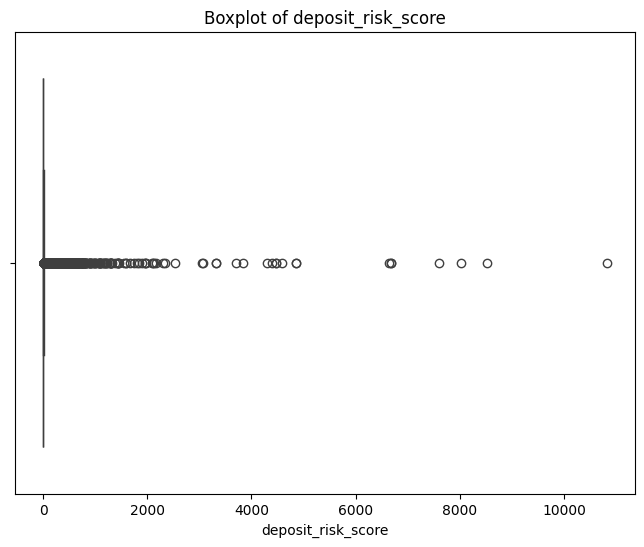

In [41]:
# Create a boxplot for deposit_risk_score
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['deposit_risk_score'])
plt.title('Boxplot of deposit_risk_score')
plt.xlabel('deposit_risk_score')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [42]:
# Check values greater than 8000 from deposit_risk_score column
print("Merchants with 'deposit_risk_score' > 8000:")
transaction_df[transaction_df['deposit_risk_score'] > 8000]

Merchants with 'deposit_risk_score' > 8000:


,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
18772,241012,Credit_Card,53.0,19337.63,10817.5540,4486,90.8357,26,NaN,NaN,6/5/2018,0
48688,241012,Credit_Card,83.0,36242.13,8019.8076,7881,36.6712,25,920.0,NaN,6/4/2018,1
97540,250934,ACH,1.0,37240.78,8520.6810,2627,2.2470,3,NaN,NaN,6/28/2018,0


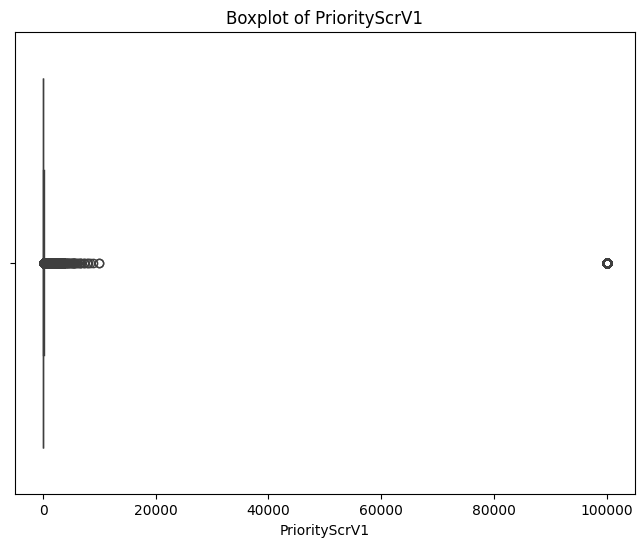

In [43]:
# Create a boxplot for PriorityScrV1
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['PriorityScrV1'])
plt.title('Boxplot of PriorityScrV1')
plt.xlabel('PriorityScrV1')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [44]:
# Check values greater than 20000 from PriorityScrV1 column
print("Merchants with 'PriorityScrV1' > 20000:")
transaction_df[transaction_df['PriorityScrV1'] > 20000]

Merchants with 'PriorityScrV1' > 20000:


,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
1,235650,Credit_Card,1.0,1000.00,2.860286,99999,85.0034,1157,NaN,NaN,5/19/2018,0
7,273115,Credit_Card,1.0,120.00,0.000000,99999,0.5495,505,NaN,NaN,6/30/2018,0
24,245181,Credit_Card,2.0,1059.00,NaN,99999,-1.0000,978,NaN,NaN,5/26/2018,0
29,248514,Credit_Card,1.0,265.00,NaN,99999,-1.0000,1091,NaN,NaN,5/26/2018,0
31,263241,Credit_Card,1.0,735.00,18.446697,99999,5.4573,159,NaN,NaN,6/23/2018,0
...,...,...,...,...,...,...,...,...,...,...,...,...
123041,264223,Credit_Card,1.0,200.00,0.000000,99999,171.5387,17,NaN,NaN,6/30/2018,0
123051,253412,Credit_Card,1.0,32.48,0.000000,99999,0.5152,910,NaN,NaN,5/19/2018,0
123052,252384,Credit_Card,1.0,115.00,0.119041,99999,0.3675,263,NaN,NaN,6/23/2018,0
123065,265996,Credit_Card,4.0,959.97,6.187028,99999,114.8978,690,NaN,NaN,6/30/2018,0


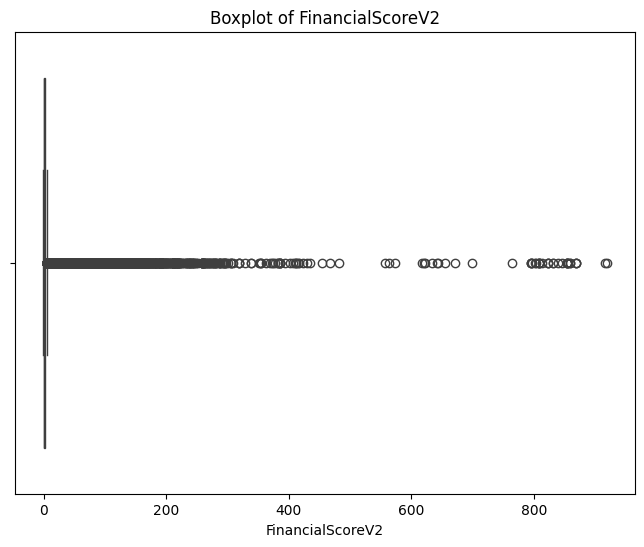

In [45]:
# Create a boxplot for FinancialScoreV2
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['FinancialScoreV2'])
plt.title('Boxplot of FinancialScoreV2')
plt.xlabel('FinancialScoreV2')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

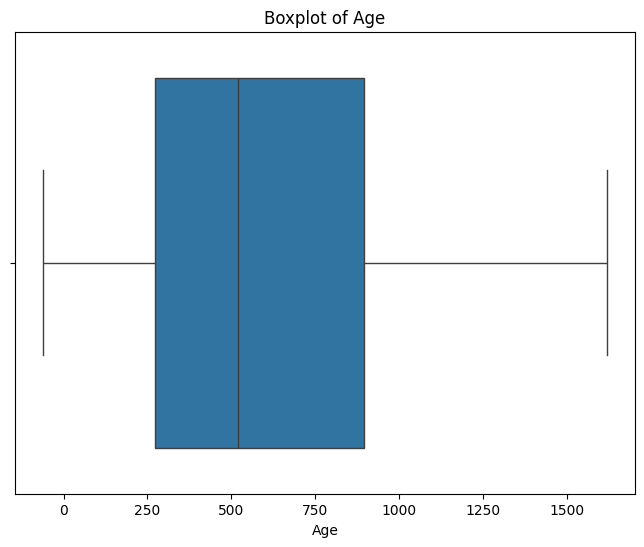

In [46]:
# Create a boxplot for Age
plt.figure(figsize=(8, 6))
sns.boxplot(x=transaction_df['Age'])
plt.title('Boxplot of Age')
plt.xlabel('Age')
#plt.xscale('log') # Use log scale on x-axis for better visualization due to skewed data
plt.show()

In [47]:
transaction_df.shape

(123082, 12)

In [48]:
# Check for missing values in transaction_df
print("Missing values in transaction_df:")
display(transaction_df.isnull().sum())

# Check for invalid values (-1 in FinancialScoreV2, 99999 in PriorityScrV1)
financial_score_invalid_count = (transaction_df['FinancialScoreV2'] == -1).sum()
print(f"\nNumber of invalid values (-1) in FinancialScoreV2: {financial_score_invalid_count}")

priority_score_invalid_count = (transaction_df['PriorityScrV1'] == 99999).sum()
print(f"Number of invalid values (99999) in PriorityScrV1: {priority_score_invalid_count}")

Missing values in transaction_df:


,0
SimuID,0
PaymentChannel,0
SaleCt,265
SalesAmt,265
deposit_risk_score,20698
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,122670
ACHRtrnAmt,122817



Number of invalid values (-1) in FinancialScoreV2: 9292
Number of invalid values (99999) in PriorityScrV1: 11090


In [49]:
# Create indicator variables for missing/invalid values
transaction_df['deposit_risk_score_missing'] = transaction_df['deposit_risk_score'].isnull().astype(int)
transaction_df['PriorityScrV1_invalid'] = (transaction_df['PriorityScrV1'] == 99999).astype(int)
transaction_df['FinancialScoreV2_invalid'] = (transaction_df['FinancialScoreV2'] == -1).astype(int)

# Analyze the proportion of risky batches for each indicator
print("Proportion of Risky Batches for Missing/Invalid deposit_risk_score:")
display(transaction_df.groupby('deposit_risk_score_missing')['is_risky'].value_counts(normalize=True).unstack())

print("\nProportion of Risky Batches for Invalid PriorityScrV1:")
display(transaction_df.groupby('PriorityScrV1_invalid')['is_risky'].value_counts(normalize=True).unstack())

print("\nProportion of Risky Batches for Invalid FinancialScoreV2:")
display(transaction_df.groupby('FinancialScoreV2_invalid')['is_risky'].value_counts(normalize=True).unstack())

Proportion of Risky Batches for Missing/Invalid deposit_risk_score:


is_risky,0,1
deposit_risk_score_missing,,
0,0.994657,0.005343
1,0.993719,0.006281



Proportion of Risky Batches for Invalid PriorityScrV1:


is_risky,0,1
PriorityScrV1_invalid,,
0,0.994321,0.005679
1,0.996303,0.003697



Proportion of Risky Batches for Invalid FinancialScoreV2:


is_risky,0,1
FinancialScoreV2_invalid,,
0,0.994455,0.005545
1,0.995050,0.004950


In [50]:
# Replace invalid values with NaN in PriorityScrV1 and FinancialScoreV2
transaction_df['PriorityScrV1'].replace(99999, np.nan, inplace=True)
transaction_df['FinancialScoreV2'].replace(-1, np.nan, inplace=True)

# Impute all missing values (original NaNs and replaced invalid values) with -999
transaction_df['deposit_risk_score'].fillna(-999, inplace=True)
transaction_df['PriorityScrV1'].fillna(-999, inplace=True)
transaction_df['FinancialScoreV2'].fillna(-999, inplace=True)

print("Missing and invalid values in selected columns have been replaced with -999.")

Missing and invalid values in selected columns have been replaced with -999.


In [51]:
# Verify that the original invalid values are no longer present
print("\nNumber of original invalid values (-1 in FinancialScoreV2, 99999 in PriorityScrV1) after handling:")
print(f"FinancialScoreV2 (-1): {(transaction_df['FinancialScoreV2'] == -1).sum()}")
print(f"PriorityScrV1 (99999): {(transaction_df['PriorityScrV1'] == 99999).sum()}")

print("\nNumber of -999 values after imputation:")
print(f"deposit_risk_score: {(transaction_df['deposit_risk_score'] == -999).sum()}")
print(f"PriorityScrV1: {(transaction_df['PriorityScrV1'] == -999).sum()}")
print(f"FinancialScoreV2: {(transaction_df['FinancialScoreV2'] == -999).sum()}")


Number of original invalid values (-1 in FinancialScoreV2, 99999 in PriorityScrV1) after handling:
FinancialScoreV2 (-1): 0
PriorityScrV1 (99999): 0

Number of -999 values after imputation:
deposit_risk_score: 20698
PriorityScrV1: 11090
FinancialScoreV2: 9292


In [52]:
# Drop rows with missing values in 'SaleCt' or 'SalesAmt'
initial_rows = transaction_df.shape[0]
transaction_df.dropna(subset=['SaleCt', 'SalesAmt'], inplace=True)
print(f"Dropped {initial_rows - transaction_df.shape[0]} rows with missing SaleCt or SalesAmt.")

# Impute missing values in 'ChargebackFinalAmt' and 'ACHRtrnAmt' with 0
transaction_df['ChargebackFinalAmt'].fillna(0, inplace=True)
transaction_df['ACHRtrnAmt'].fillna(0, inplace=True)

Dropped 265 rows with missing SaleCt or SalesAmt.


In [53]:
transaction_df.isnull().sum()

,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


In [54]:
transaction_df.shape

(122817, 15)

In [55]:
transaction_df['is_chargeback'] = (transaction_df['ChargebackFinalAmt'] > 0).astype(int)
transaction_df['is_ach_return'] = (transaction_df['ACHRtrnAmt'] > 0).astype(int)

In [56]:
transaction_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,6/15/2018,0,0,0,0,0,0
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,5/19/2018,0,0,1,0,0,0
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,6/11/2018,0,0,0,0,0,0
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,6/11/2018,0,0,0,0,0,0
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,5/29/2018,0,1,0,1,0,0


# **4. Merging Dataframes and binning**

In [57]:
# Merge merchants_df and transaction_df on SimuID
merged_df = pd.merge(transaction_df, merchants_df, on='SimuID', how='inner')

# Display the first few rows of the merged dataframe
display(merged_df.head())

# Display the shape of the merged dataframe
print("\nShape of the merged dataframe:", merged_df.shape)

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,6/15/2018,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,3/30/2017
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,5/19/2018,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,8/14/2017
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,6/11/2018,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,4/25/2016
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,6/11/2018,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,9/1/2017
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,5/29/2018,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,8/16/2017



Shape of the merged dataframe: (120466, 26)


In [58]:
merged_df.isnull().sum()

,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


In [59]:
# creating vantage score buckets
bins = [0, 550, 700, 850, 1000]
labels = ['Poor', 'Fair', 'Good', 'Excellent']
merged_df['VantageScoreBucket'] = pd.cut(merged_df['AppVantageScr'], bins=bins, labels=labels)

In [60]:
merged_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,VantageScoreBucket
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,6/15/2018,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,3/30/2017,Good
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,5/19/2018,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,8/14/2017,Fair
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,6/11/2018,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,4/25/2016,Excellent
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,6/11/2018,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,9/1/2017,Excellent
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,5/29/2018,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,8/16/2017,Excellent


In [61]:
# creating salesamt and salesct buckets
merged_df['SalesAmtBucket'] = pd.qcut(
    merged_df['SalesAmt'],
    q=4,
    labels=['low_sales', 'mid_sales', 'high_sales', 'very_high_sales']
)

In [62]:
# creating vantage score buckets
bins = [-1, 2, 5, 10, merged_df['SaleCt'].max()]
labels = ['0-2_sales', '2-5_sales', '6-10_sales', '10+_sales']
merged_df['SalesCtBucket'] = pd.cut(merged_df['SaleCt'], bins=bins, labels=labels)

In [63]:
merged_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,VantageScoreBucket,SalesAmtBucket,SalesCtBucket
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,6/15/2018,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,3/30/2017,Good,high_sales,0-2_sales
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,5/19/2018,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,8/14/2017,Fair,high_sales,0-2_sales
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,6/11/2018,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,4/25/2016,Excellent,high_sales,0-2_sales
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,6/11/2018,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,9/1/2017,Excellent,high_sales,0-2_sales
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,5/29/2018,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,8/16/2017,Excellent,high_sales,0-2_sales


In [64]:
# creating age buckets
merged_df['TenureBucket'] = pd.cut(
    merged_df['Age'],
    bins=[0, 30, 90, 10000],
    labels=['New', 'Young', 'Tenured']
)

In [65]:
merged_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,VantageScoreBucket,SalesAmtBucket,SalesCtBucket,TenureBucket
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,6/15/2018,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,3/30/2017,Good,high_sales,0-2_sales,New
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,5/19/2018,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,8/14/2017,Fair,high_sales,0-2_sales,Tenured
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,6/11/2018,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,4/25/2016,Excellent,high_sales,0-2_sales,New
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,6/11/2018,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,9/1/2017,Excellent,high_sales,0-2_sales,Tenured
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,5/29/2018,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,8/16/2017,Excellent,high_sales,0-2_sales,Tenured


In [66]:
# Create binary indicators for AppPublicRecords, AppCollections, and AppAmountPastDue
merged_df['has_public_records'] = (merged_df['AppPublicRecords'] > 0).astype(int)
merged_df['has_collections'] = (merged_df['AppCollections'] > 0).astype(int)
merged_df['has_amount_past_due'] = (merged_df['AppAmountPastDue'] > 0).astype(int)

# **5. Analysis - Chargeback and ACH Return Rate by different segments**

## 5.1 Chargeback and ACH Return rate by Tenure

In [67]:
# Risk rates across tenure
merged_df.groupby('TenureBucket')['is_chargeback'].mean()

,is_chargeback
TenureBucket,
New,0.003350
Young,0.002719
Tenured,0.003097


In [68]:
merged_df.groupby('TenureBucket')['is_ach_return'].mean()

,is_ach_return
TenureBucket,
New,0.000000
Young,0.000136
Tenured,0.002378


**Insight:**

While there are some variations, the differences in chargeback and ACH return rates across 'New', 'Young', and 'Tenured' merchants are not as pronounced or consistently trending as with Sales Count or Sales Amount. New merchants have a slightly higher chargeback rate, and Tenured merchants have a higher ACH return rate, but the overall differences are relatively small.

## 5.2 Chargeback and ACH Return rate by Vantage Score

In [69]:
# Risk rates across VantageScore
merged_df.groupby('VantageScoreBucket')['is_chargeback'].mean()

,is_chargeback
VantageScoreBucket,
Poor,0.011623
Fair,0.003095
Good,0.003122
Excellent,0.002587


In [70]:
# Risk rates across tenure
merged_df.groupby('VantageScoreBucket')['is_ach_return'].mean()

,is_ach_return
VantageScoreBucket,
Poor,0.001788
Fair,0.002104
Good,0.002102
Excellent,0.002309


**Insights:**

Merchants with 'Poor' Vantage Scores show a considerably higher chargeback rate compared to those with 'Fair', 'Good', or 'Excellent' scores. The trend is less clear for ACH returns across Vantage Score buckets.

## 5.3 Chargeback and ACH Return rate by Sales Amount

In [71]:
# Chargeback rate by SalesAmt bucket
merged_df.groupby('SalesAmtBucket')['is_chargeback'].mean()

,is_chargeback
SalesAmtBucket,
low_sales,0.001382
mid_sales,0.001865
high_sales,0.002638
very_high_sales,0.006575


In [72]:
# Chargeback rate by SalesAmt bucket
merged_df.groupby('SalesAmtBucket')['is_ach_return'].mean()

,is_ach_return
SalesAmtBucket,
low_sales,0.000757
mid_sales,0.001499
high_sales,0.002338
very_high_sales,0.004051


**Insights:**

Batches with higher sales amounts (particularly in the highest quantile bucket) tend to have higher chargeback and ACH return rates.

## 5.4 Chargeback and ACH Return rate by Sales Count

In [73]:
# Chargeback rate by SalesCt bucket
merged_df.groupby('SalesCtBucket')['is_chargeback'].mean()

,is_chargeback
SalesCtBucket,
0-2_sales,0.001819
2-5_sales,0.004093
6-10_sales,0.010901
10+_sales,0.025833


In [74]:
# Chargeback rate by SalesCt bucket
merged_df.groupby('SalesCtBucket')['is_ach_return'].mean()

,is_ach_return
SalesCtBucket,
0-2_sales,0.001536
2-5_sales,0.003551
6-10_sales,0.003825
10+_sales,0.011557


**Insights:**

There is a clear trend of increasing chargeback and ACH return rates as the number of sales transactions per batch increases. Batches with more sales (especially in the '6-10_sales' and '10+_sales' buckets) show significantly higher risk rates.



## 5.5 Chargeback and ACH Return rate by Tenure & Vantage Score

In [75]:
# Risk by Tenure + Vantage
pd.crosstab(merged_df['TenureBucket'], merged_df['VantageScoreBucket'], values=merged_df['is_chargeback'], aggfunc='mean')

VantageScoreBucket,Poor,Fair,Good,Excellent
TenureBucket,,,,
New,0.000000,0.002107,0.004386,0.002801
Young,0.000000,0.001510,0.004075,0.002208
Tenured,0.012776,0.003222,0.003009,0.002498


In [76]:
# Risk by Tenure + Vantage
pd.crosstab(merged_df['TenureBucket'], merged_df['VantageScoreBucket'], values=merged_df['is_ach_return'], aggfunc='mean')

VantageScoreBucket,Poor,Fair,Good,Excellent
TenureBucket,,,,
New,0.000000,0.000000,0.000000,0.000000
Young,0.000000,0.000503,0.000000,0.000000
Tenured,0.001966,0.002297,0.002341,0.002528


## 5.6 Chargeback and ACH Return rate by Tenure & Sales Amt

In [77]:
# Risk by Tenure + SalesAmtBucket
pd.crosstab(merged_df['TenureBucket'], merged_df['SalesAmtBucket'], values=merged_df['is_chargeback'], aggfunc='mean')

SalesAmtBucket,low_sales,mid_sales,high_sales,very_high_sales
TenureBucket,,,,
New,0.000919,0.003226,0.003219,0.006445
Young,0.000983,0.003140,0.001763,0.005266
Tenured,0.001440,0.001666,0.002654,0.006601


In [78]:
# Risk by Tenure + SalesAmtBucket
pd.crosstab(merged_df['TenureBucket'], merged_df['SalesAmtBucket'], values=merged_df['is_ach_return'], aggfunc='mean')

SalesAmtBucket,low_sales,mid_sales,high_sales,very_high_sales
TenureBucket,,,,
New,0.000000,0.000000,0.000000,0.000000
Young,0.000000,0.000000,0.000588,0.000000
Tenured,0.000849,0.001666,0.002543,0.004437


## 5.6 Chargeback and ACH Return rate by Tenure & Sales Count

In [79]:
# Risk by Tenure + SalesCtBucket
pd.crosstab(merged_df['TenureBucket'], merged_df['SalesCtBucket'], values=merged_df['is_chargeback'], aggfunc='mean')

SalesCtBucket,0-2_sales,2-5_sales,6-10_sales,10+_sales
TenureBucket,,,,
New,0.002370,0.005935,0.000000,0.056604
Young,0.001774,0.003841,0.004184,0.037313
Tenured,0.001744,0.004073,0.011506,0.024936


In [80]:
# Risk by Tenure + SalesCtBucket
pd.crosstab(merged_df['TenureBucket'], merged_df['SalesCtBucket'], values=merged_df['is_ach_return'], aggfunc='mean')

SalesCtBucket,0-2_sales,2-5_sales,6-10_sales,10+_sales
TenureBucket,,,,
New,0.000000,0.000000,0.000000,0.000000
Young,0.000161,0.000000,0.000000,0.000000
Tenured,0.001697,0.003815,0.004109,0.012468


## 5.7 Chargeback and ACH Return rate by Merchant Categories

In [81]:
merged_df.groupby('MCCDescription')['is_chargeback'].mean().sort_values(ascending=False).head(10)

,is_chargeback
MCCDescription,
Orthopedic Goods - Prosthetic Devices,0.142857
"Reupholstery and Furniture Repair, Furniture Refinishing",0.095238
Motorcycle Shops and Dealers,0.062500
"Photofinishing Laboratories, Photo Developing",0.052632
Home Supply Warehouse,0.033333
Plumbing and Heating Equipment,0.028571
Beauty Shops and Barber Shops,0.023295
Variety Stores,0.021277
Motion Picture Theaters,0.018018


In [82]:
merged_df.groupby('MCCDescription')['is_ach_return'].mean().sort_values(ascending=False).head(10)

,is_ach_return
MCCDescription,
"Chiropodists, Podiatrists",0.032787
"Men's, Women's, and Children's Uniforms and Commercial Clothing",0.024390
"Gift, Card, Novelty, and Souvenir Shops",0.015000
Office and Commercial Furniture,0.014706
Nursing and Personal Care Facilities,0.013746
"Drinking Places (Alcoholic Beverages) - Bars, Taverns, Nightclubs, Cocktail Lounges, Discotheques",0.013029
"Miscellaneous Food Stores - Specialty Stores, Markets, Convenience Stores, and Vending Machines",0.012987
Automotive Body Repair Shops,0.011268
"Drapery, Upholstery, and Window Coverings Stores",0.009050


**Insights:**

Some merchant categories appear to have notably higher chargeback or ACH return rates than others. This suggests that the type of business can be a risk factor

## 5.8 Chargeback and ACH Return rate by HVC

In [83]:
# Risk rates by SBG_HVC
merged_df.groupby('SBG_HVC')['is_chargeback'].mean()

,is_chargeback
SBG_HVC,
0,0.003166
1,0.002873


In [84]:
# Risk rates by SBG_HVC
merged_df.groupby('SBG_HVC')['is_ach_return'].mean()

,is_ach_return
SBG_HVC,
0,0.002212
1,0.001915


**Insights:**

There is a very small difference in chargeback and ACH return rates between HVC (High-Value Customer) and non-HVC merchants, with HVC merchants showing slightly lower rates.

## 5.9 Chargeback and ACH Return rate by has_public_records

In [85]:
merged_df.groupby('has_public_records')['is_chargeback'].mean()

,is_chargeback
has_public_records,
0,0.003168
1,0.002649


In [86]:
merged_df.groupby('has_public_records')['is_ach_return'].mean()

,is_ach_return
has_public_records,
0,0.002118
1,0.002493


**Insights:**

Merchants with public records do not show a consistently higher chargeback or ACH return rate; the relationship appears weak or even slightly inverse based on the binary indicator.

## 5.10 Chargeback and ACH Return rate by has_collections

In [87]:
merged_df.groupby('has_collections')['is_chargeback'].mean()

,is_chargeback
has_collections,
0,0.002824
1,0.004264


In [88]:
merged_df.groupby('has_collections')['is_ach_return'].mean()

,is_ach_return
has_collections,
0,0.002201
1,0.001987


**Insights:**

Merchants with a history of collections ('has_collections' = 1) have a higher chargeback rate compared to those without collections

## 5.11 Chargeback and ACH Return rate by has_amount_past_due


In [89]:
merged_df.groupby('has_amount_past_due')['is_chargeback'].mean()

,is_chargeback
has_amount_past_due,
0,0.002716
1,0.004516


In [90]:
merged_df.groupby('has_amount_past_due')['is_ach_return'].mean()

,is_ach_return
has_amount_past_due,
0,0.002162
1,0.002145


**Insights:**

Merchants with any amount past due ('has_amount_past_due' = 1) also show a higher chargeback rate compared to those without.

## 5.12 Chargeback and ACH Return rate by deposit_risk_score_missing

In [91]:
merged_df.groupby('deposit_risk_score_missing')['is_chargeback'].mean()

,is_chargeback
deposit_risk_score_missing,
0,0.003054
1,0.003405


In [92]:
merged_df.groupby('deposit_risk_score_missing')['is_ach_return'].mean()

,is_ach_return
deposit_risk_score_missing,
0,0.002026
1,0.002813


**Inisghts:**

Batches where the deposit_risk_score was missing showed a slightly higher proportion of risky batches.

## 5.13 Chargeback and ACH Return rate by PriorityScrV1_invalid

In [93]:
merged_df.groupby('PriorityScrV1_invalid')['is_chargeback'].mean()

,is_chargeback
PriorityScrV1_invalid,
0,0.003240
1,0.001837


In [94]:
merged_df.groupby('PriorityScrV1_invalid')['is_ach_return'].mean()

,is_ach_return
PriorityScrV1_invalid,
0,0.002199
1,0.001745


**Insights:**

Interestingly, batches with the invalid PriorityScrV1 value showed a lower proportion of risky batches.

## 5.14 Chargeback and ACH Return rate by FinancialScoreV2_invalid

In [95]:
merged_df.groupby('FinancialScoreV2_invalid')['is_chargeback'].mean()

,is_chargeback
FinancialScoreV2_invalid,
0,0.003116
1,0.003080


In [96]:
merged_df.groupby('FinancialScoreV2_invalid')['is_ach_return'].mean()

,is_ach_return
FinancialScoreV2_invalid,
0,0.002182
1,0.001870


**Insights:**

The invalid FinancialScoreV2 value (-1) did not show a notable difference in the proportion of risky batches.

# **6. Aggregation and Feature Engineering**

## 6.1 Aggregating transaction level features to merchant df

In [97]:
# Aggregate transaction data to the merchant level
merchant_agg_df = transaction_df.groupby('SimuID').agg(
    total_sales_amount=('SalesAmt', 'sum'),
    total_sale_count=('SaleCt', 'sum'),
    average_sales_amount=('SalesAmt', 'mean'),
    total_chargeback_amount=('ChargebackFinalAmt', 'sum'),
    total_ach_return_amount=('ACHRtrnAmt', 'sum'),
    total_risky_batches=('is_risky', 'sum'),
    transaction_count=('SimuID', 'count'),
    risky_transaction_count=('is_risky', lambda x: (x > 0).sum()) # Count of transactions where is_risky is 1
).reset_index()

merchants_df = pd.merge(merchants_df, merchant_agg_df, on='SimuID', how='left')

# Display the shape of the updated merchants_df
print("\nShape of merchants_df after merging:", merchants_df.shape)


Shape of merchants_df after merging: (15131, 18)


In [98]:
merged_df.isnull().sum()

,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


## 6.2 Calculating historical chargeback rate and ACH rate per merchant

In [99]:
# Calculate historical chargeback rate per merchant
# Handle cases where total_sales_amount is zero to avoid division by zero
merchants_df['chargeback_rate'] = merchants_df['total_chargeback_amount'] / merchants_df['total_sales_amount']
merchants_df['chargeback_rate'].fillna(0, inplace=True)
merchants_df.loc[merchants_df['total_sales_amount'] == 0, 'chargeback_rate'] = 0

# Calculate historical ACH return rate per merchant
# Handle cases where total_sales_amount is zero to avoid division by zero
merchants_df['ach_return_rate'] = merchants_df['total_ach_return_amount'] / merchants_df['total_sales_amount']
merchants_df['ach_return_rate'].fillna(0, inplace=True)
merchants_df.loc[merchants_df['total_sales_amount'] == 0, 'ach_return_rate'] = 0

In [100]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count,chargeback_rate,ach_return_rate
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,3/5/2018,9000.00,4.0,3000.000000,0.0,0.0,0,3,0,0.0,0.0
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,3/23/2016,3292.50,14.0,299.318182,0.0,0.0,0,11,0,0.0,0.0
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,6/20/2017,20420.41,50.0,729.300357,0.0,0.0,0,28,0,0.0,0.0
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,9/28/2016,17502.88,2.0,8751.440000,0.0,0.0,0,2,0,0.0,0.0
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,12/3/2017,4304.60,7.0,717.433333,0.0,0.0,0,6,0,0.0,0.0


## 6.3 Calculating recency features

In [101]:
# Ensure date columns are in datetime format
merchants_df['AccountOpenDate'] = pd.to_datetime(merchants_df['AccountOpenDate'])
transaction_df['Batch_Clear_Date'] = pd.to_datetime(transaction_df['Batch_Clear_Date'])

# Define a reference date (e.g., the latest batch clear date in the dataset)
reference_date = transaction_df['Batch_Clear_Date'].max()

In [102]:
# Calculate recency of last batch for each merchant
last_batch_dates = transaction_df.groupby('SimuID')['Batch_Clear_Date'].max().reset_index()
last_batch_dates.rename(columns={'Batch_Clear_Date': 'latest_batch_clear_date'}, inplace=True)
merchants_df = pd.merge(merchants_df, last_batch_dates, on='SimuID', how='left')
merchants_df['recency_last_batch'] = (reference_date - merchants_df['latest_batch_clear_date']).dt.days.fillna(9999) # Fill NaN for merchants with no transactions


In [103]:
# Calculate recency of last risky batch for each merchant
risky_transactions = transaction_df[transaction_df['is_risky'] == 1]
last_risky_batch_dates = risky_transactions.groupby('SimuID')['Batch_Clear_Date'].max().reset_index()
last_risky_batch_dates.rename(columns={'Batch_Clear_Date': 'last_risky_batch_date'}, inplace=True)
merchants_df = pd.merge(merchants_df, last_risky_batch_dates, on='SimuID', how='left')
merchants_df['recency_last_risky_batch'] = (reference_date - merchants_df['last_risky_batch_date']).dt.days.fillna(9999) # Fill NaN for merchants with no risky transactions

In [104]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count,chargeback_rate,ach_return_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,2018-03-05,9000.00,4.0,3000.000000,0.0,0.0,0,3,0,0.0,0.0,2018-06-28,2,NaT,9999.0
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,2016-03-23,3292.50,14.0,299.318182,0.0,0.0,0,11,0,0.0,0.0,2018-06-18,12,NaT,9999.0
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,2017-06-20,20420.41,50.0,729.300357,0.0,0.0,0,28,0,0.0,0.0,2018-06-29,1,NaT,9999.0
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,2016-09-28,17502.88,2.0,8751.440000,0.0,0.0,0,2,0,0.0,0.0,2018-06-12,18,NaT,9999.0
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,2017-12-03,4304.60,7.0,717.433333,0.0,0.0,0,6,0,0.0,0.0,2018-06-23,7,NaT,9999.0


In [105]:
# Calculate average risk rates per MCC Description using the merchants_df
mcc_merchant_risk_rates = merchants_df.groupby('MCCDescription').agg(
    avg_merchant_chargeback_rate=('chargeback_rate', 'mean'),
    avg_merchant_ach_return_rate=('ach_return_rate', 'mean'),
    merchant_count=('SimuID', 'count') # Count of merchants in each MCC
).reset_index()

# Calculate the overall average chargeback and ACH return rates across all merchants
overall_avg_chargeback_rate = merchants_df['chargeback_rate'].mean()
overall_avg_ach_return_rate = merchants_df['ach_return_rate'].mean()

print(f"Overall average merchant chargeback rate: {overall_avg_chargeback_rate:.4f}")
print(f"Overall average merchant ACH return rate: {overall_avg_ach_return_rate:.4f}")

Overall average merchant chargeback rate: 0.0021
Overall average merchant ACH return rate: 0.0011


In [106]:
min_merchants_for_mcc_risk = 10 # Define a minimum number of merchants in an MCC to consider its average rate

# Identify high-risk MCC Descriptions where the MCC average is > overall average
high_risk_mcc_descriptions = mcc_merchant_risk_rates[
    (mcc_merchant_risk_rates['merchant_count'] >= min_merchants_for_mcc_risk) &
    ((mcc_merchant_risk_rates['avg_merchant_chargeback_rate'] > overall_avg_chargeback_rate) |
     (mcc_merchant_risk_rates['avg_merchant_ach_return_rate'] > overall_avg_ach_return_rate))
]['MCCDescription'].tolist()

print(f"\nIdentified High-Risk MCC Descriptions (MCC average > overall average and min merchants): {high_risk_mcc_descriptions}")

# Create the boolean column in the merchants_df
merchants_df['is_high_risk_mcc'] = merchants_df['MCCDescription'].apply(
    lambda x: 1 if x in high_risk_mcc_descriptions else 0
)



Identified High-Risk MCC Descriptions (MCC average > overall average and min merchants): ['Air Conditioning, Heating, and Plumbing Contractors', 'Art Dealers and Galleries', 'Bakeries', 'Beauty Shops and Barber Shops', 'Business Services not elsewhere classified', 'Carpet and Upholstery Cleaning', 'Caterers', 'Civic, Social, and Fraternal Associations', 'Commercial Sports, Professional Sports Clubs, Athletic Fields, Sports Promoters', 'Computer Maintenance, Repair, and Services not elsewhere classified', 'Computer Network/Information Services', 'Computers, Computer Peripheral Equipment, Software', 'Concrete Work Contractors', 'Construction Materials not elsewhere classified', 'Contractors, Special Trade not elsewhere classified', 'Cosmetic Stores', 'Doctors not elsewhere classified', 'Drapery, Upholstery, and Window Coverings Stores', 'Durable Goods not elsewhere classified', 'Engineering, Architectural, and Surveying Services', 'Equipment, Furniture, and Home Furnishings Stores (exce

In [107]:
merchants_df.shape

(15131, 25)

In [108]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count,chargeback_rate,ach_return_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch,is_high_risk_mcc
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,2018-03-05,9000.00,4.0,3000.000000,0.0,0.0,0,3,0,0.0,0.0,2018-06-28,2,NaT,9999.0,0
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,2016-03-23,3292.50,14.0,299.318182,0.0,0.0,0,11,0,0.0,0.0,2018-06-18,12,NaT,9999.0,1
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,2017-06-20,20420.41,50.0,729.300357,0.0,0.0,0,28,0,0.0,0.0,2018-06-29,1,NaT,9999.0,0
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,2016-09-28,17502.88,2.0,8751.440000,0.0,0.0,0,2,0,0.0,0.0,2018-06-12,18,NaT,9999.0,1
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,2017-12-03,4304.60,7.0,717.433333,0.0,0.0,0,6,0,0.0,0.0,2018-06-23,7,NaT,9999.0,0


# **7. Merge and Feature selection**

## 7.1 Merging transaction and newly created merchant features

In [109]:
# Select the new merchant-level features from merchants_df
merchant_historical_features = merchants_df[['SimuID', 'total_sales_amount', 'total_sale_count',
                                              'average_sales_amount', 'total_chargeback_amount',
                                              'total_ach_return_amount', 'total_risky_batches',
                                              'transaction_count', 'risky_transaction_count',
                                              'chargeback_rate', 'ach_return_rate',
                                              'recency_last_batch', 'recency_last_risky_batch','is_high_risk_mcc']]

final_df = pd.merge(merged_df, merchant_historical_features, on='SimuID', how='left')

In [110]:
final_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,VantageScoreBucket,SalesAmtBucket,SalesCtBucket,TenureBucket,has_public_records,has_collections,has_amount_past_due,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count,chargeback_rate,ach_return_rate,recency_last_batch,recency_last_risky_batch,is_high_risk_mcc
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,6/15/2018,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,3/30/2017,Good,high_sales,0-2_sales,New,0,0,0,3890.66,4.0,1945.330000,0.0,0.0,0,2,0,0.000000,0.0,15,9999.0,0
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,5/19/2018,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,8/14/2017,Fair,high_sales,0-2_sales,Tenured,0,0,1,56199.67,76.0,1652.931471,3000.0,0.0,4,34,4,0.053381,0.0,0,21.0,0
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,6/11/2018,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,4/25/2016,Excellent,high_sales,0-2_sales,New,0,0,0,23137.46,45.0,1446.091250,0.0,0.0,0,16,0,0.000000,0.0,1,9999.0,0
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,6/11/2018,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,9/1/2017,Excellent,high_sales,0-2_sales,Tenured,0,0,0,31375.94,95.0,1012.127097,200.0,0.0,1,31,1,0.006374,0.0,0,31.0,1
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,5/29/2018,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,8/16/2017,Excellent,high_sales,0-2_sales,Tenured,0,0,0,12700.00,16.0,1058.333333,0.0,0.0,0,12,0,0.000000,0.0,1,9999.0,0


In [111]:
final_df.shape

(120466, 46)

## 7.2 Create transaction-level features

In [112]:
# Create transaction-level features in the final_df

# Feature 1: Ratio of current sales amount to merchant's average sales amount
# Handle cases where average_sales_amount is zero to avoid division by zero
final_df['sales_amount_to_avg_merchant_sales'] = final_df['SalesAmt'] / final_df['average_sales_amount']
final_df['sales_amount_to_avg_merchant_sales'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf with NaN
final_df['sales_amount_to_avg_merchant_sales'].fillna(0, inplace=True) # Impute NaN (e.g., if average_sales_amount was 0 or NaN)


In [113]:
# Feature 2: Ratio of current sale count to merchant's average sale count
# We need average sale count per batch for the merchant. Let's calculate it first if not already available.
# Assuming total_sale_count is the sum of SaleCt for the merchant and transaction_count is the number of batches
final_df['avg_merchant_sale_count'] = final_df['total_sale_count'] / final_df['transaction_count']
final_df['avg_merchant_sale_count'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf with NaN
final_df['avg_merchant_sale_count'].fillna(0, inplace=True) # Impute NaN

# Now calculate the ratio
final_df['sale_count_to_avg_merchant_sale_count'] = final_df['SaleCt'] / final_df['avg_merchant_sale_count']
final_df['sale_count_to_avg_merchant_sale_count'].replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf with NaN
final_df['sale_count_to_avg_merchant_sale_count'].fillna(0, inplace=True) # Impute NaN

In [114]:
# Ensure 'Batch_Clear_Date' is in datetime format before accessing .dt
final_df['Batch_Clear_Date'] = pd.to_datetime(final_df['Batch_Clear_Date'])

# Feature 3: Day of the week of the batch date
final_df['batch_day_of_week'] = final_df['Batch_Clear_Date'].dt.day_name()

In [115]:
final_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,is_chargeback,is_ach_return,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,VantageScoreBucket,SalesAmtBucket,SalesCtBucket,TenureBucket,has_public_records,has_collections,has_amount_past_due,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count,chargeback_rate,ach_return_rate,recency_last_batch,recency_last_risky_batch,is_high_risk_mcc,sales_amount_to_avg_merchant_sales,avg_merchant_sale_count,sale_count_to_avg_merchant_sale_count,batch_day_of_week
0,258132,Credit_Card,2.0,698.66,326.560330,237.0,10.1593,2,0.0,0.0,2018-06-15,0,0,0,0,0,0,8398,Charitable and Social Service Organizations,QBMS for QBO,0,781.0,0.0,0.0,0.0,3/30/2017,Good,high_sales,0-2_sales,New,0,0,0,3890.66,4.0,1945.330000,0.0,0.0,0,2,0,0.000000,0.0,15,9999.0,0,0.359147,2.000000,1.000000,Friday
1,235650,Credit_Card,1.0,1000.00,2.860286,-999.0,85.0034,1157,0.0,0.0,2018-05-19,0,0,1,0,0,0,7392,"Management, Consulting, and Public Relations S...",QBMS for QBO,0,592.0,0.0,0.0,11.0,8/14/2017,Fair,high_sales,0-2_sales,Tenured,0,0,1,56199.67,76.0,1652.931471,3000.0,0.0,4,34,4,0.053381,0.0,0,21.0,0,0.604986,2.235294,0.447368,Saturday
2,241608,ACH,2.0,622.00,0.000000,76.0,2.3248,6,0.0,0.0,2018-06-11,0,0,0,0,0,0,5996,Swimming Pools - Sales and Service,QBMS for QBO,1,920.0,0.0,0.0,0.0,4/25/2016,Excellent,high_sales,0-2_sales,New,0,0,0,23137.46,45.0,1446.091250,0.0,0.0,0,16,0,0.000000,0.0,1,9999.0,0,0.430125,2.812500,0.711111,Monday
3,271779,Credit_Card,2.0,500.00,6.754413,6.0,113.7732,690,0.0,0.0,2018-06-11,0,0,0,0,0,0,7379,"Computer Maintenance, Repair, and Services not...",QBMS for QBO,0,851.0,0.0,0.0,0.0,9/1/2017,Excellent,high_sales,0-2_sales,Tenured,0,0,0,31375.94,95.0,1012.127097,200.0,0.0,1,31,1,0.006374,0.0,0,31.0,1,0.494009,3.064516,0.652632,Monday
4,261441,Credit_Card,1.0,850.00,-999.000000,8.0,-999.0000,307,0.0,0.0,2018-05-29,0,1,0,1,0,0,8931,"Accounting, Auditing, and Bookkeeping Services",QBMS for QBO,0,956.0,0.0,0.0,0.0,8/16/2017,Excellent,high_sales,0-2_sales,Tenured,0,0,0,12700.00,16.0,1058.333333,0.0,0.0,0,12,0,0.000000,0.0,1,9999.0,0,0.803150,1.333333,0.750000,Tuesday


In [116]:
final_df.isnull().sum()

,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


## 7.3 Correlation heatmap

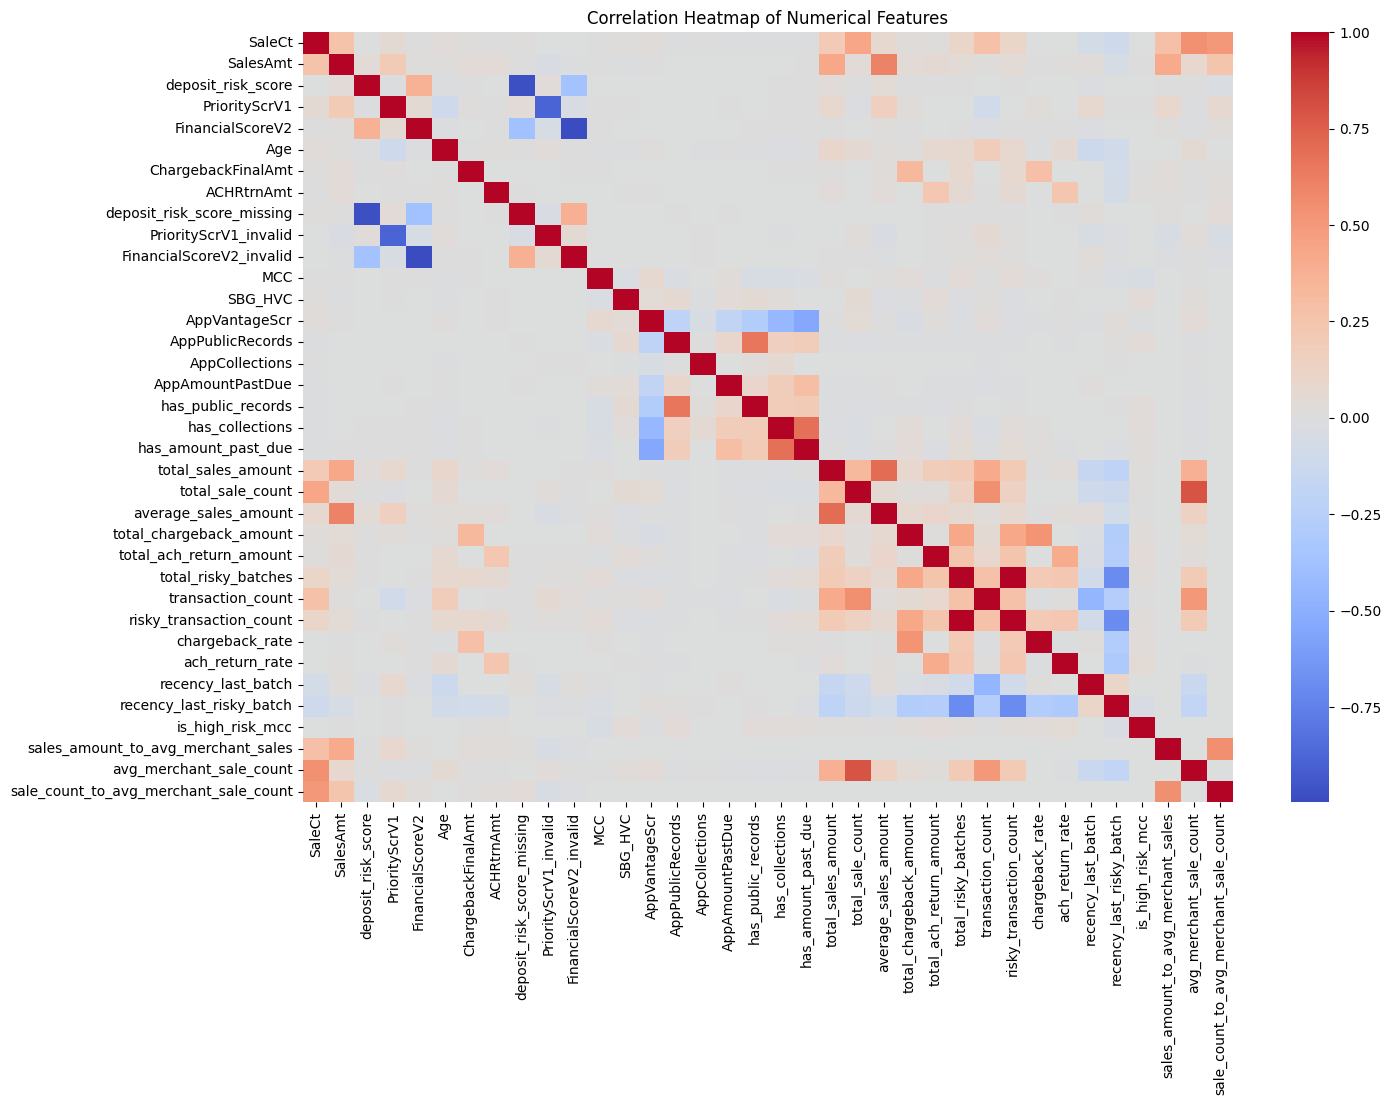

In [117]:
# Select numerical columns from the final_df
# Exclude identifier columns, the target variable, and explicitly exclude categorical/bucket columns
numerical_cols = final_df.select_dtypes(include=np.number).columns.tolist()

# Identify categorical and bucket columns to exclude from correlation calculation
categorical_cols_to_exclude = final_df.select_dtypes(include=['object', 'category']).columns.tolist()
# Also exclude date columns and identifiers
other_cols_to_exclude = ['SimuID', 'is_risky', 'is_chargeback', 'is_ach_return', 'Batch_Clear_Date', 'AccountOpenDate', 'MCCDescription','batch_day_of_week']

# Combine all columns to exclude
all_cols_to_exclude = list(set(categorical_cols_to_exclude + other_cols_to_exclude))

# Filter numerical columns to exclude those in the combined exclude list
numerical_cols_for_heatmap = [col for col in numerical_cols if col not in all_cols_to_exclude]

# Calculate the correlation matrix using only the selected numerical columns
correlation_matrix = final_df[numerical_cols_for_heatmap].corr()

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## 7.4 Feature transformation

In [118]:
from sklearn.preprocessing import StandardScaler

# Identify categorical and numerical columns
# Exclude identifiers, date columns, target variable, and MCCDescription
categorical_cols = final_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = final_df.select_dtypes(include=np.number).columns.tolist()

cols_to_exclude = ['SimuID', 'Batch_Clear_Date', 'AccountOpenDate', 'MCCDescription',
                   'is_risky', 'is_chargeback', 'is_ach_return'] # Exclude identifiers, dates, targets, high-cardinality categorical

categorical_cols_for_transform = [col for col in categorical_cols if col not in cols_to_exclude]
numerical_cols_for_transform = [col for col in numerical_cols if col not in cols_to_exclude]

print(f"Categorical columns for encoding: {categorical_cols_for_transform}")
print(f"Numerical columns for scaling: {numerical_cols_for_transform}")

Categorical columns for encoding: ['PaymentChannel', 'Product', 'VantageScoreBucket', 'SalesAmtBucket', 'SalesCtBucket', 'TenureBucket', 'batch_day_of_week']
Numerical columns for scaling: ['SaleCt', 'SalesAmt', 'deposit_risk_score', 'PriorityScrV1', 'FinancialScoreV2', 'Age', 'ChargebackFinalAmt', 'ACHRtrnAmt', 'deposit_risk_score_missing', 'PriorityScrV1_invalid', 'FinancialScoreV2_invalid', 'MCC', 'SBG_HVC', 'AppVantageScr', 'AppPublicRecords', 'AppCollections', 'AppAmountPastDue', 'has_public_records', 'has_collections', 'has_amount_past_due', 'total_sales_amount', 'total_sale_count', 'average_sales_amount', 'total_chargeback_amount', 'total_ach_return_amount', 'total_risky_batches', 'transaction_count', 'risky_transaction_count', 'chargeback_rate', 'ach_return_rate', 'recency_last_batch', 'recency_last_risky_batch', 'is_high_risk_mcc', 'sales_amount_to_avg_merchant_sales', 'avg_merchant_sale_count', 'sale_count_to_avg_merchant_sale_count']


In [119]:
# Perform One-Hot Encoding on categorical columns
final_df_encoded_cats = pd.get_dummies(final_df[categorical_cols_for_transform], drop_first=True)

# Scale numerical columns
scaler = StandardScaler()
final_df_scaled_nums = scaler.fit_transform(final_df[numerical_cols_for_transform])
final_df_scaled_nums = pd.DataFrame(final_df_scaled_nums, columns=numerical_cols_for_transform, index=final_df.index)


# Combine the transformed features

final_df_transformed = pd.concat([
    final_df[['is_risky']], # Include target
    final_df_encoded_cats,
    final_df_scaled_nums
], axis=1)

In [120]:
final_df_transformed.shape

(120466, 57)

In [121]:
final_df_transformed.head()

,is_risky,PaymentChannel_Credit_Card,Product_GoPayment Free,Product_QBMS for QBO,VantageScoreBucket_Fair,VantageScoreBucket_Good,VantageScoreBucket_Excellent,SalesAmtBucket_mid_sales,SalesAmtBucket_high_sales,SalesAmtBucket_very_high_sales,SalesCtBucket_2-5_sales,SalesCtBucket_6-10_sales,SalesCtBucket_10+_sales,TenureBucket_Young,TenureBucket_Tenured,batch_day_of_week_Monday,batch_day_of_week_Saturday,batch_day_of_week_Sunday,batch_day_of_week_Thursday,batch_day_of_week_Tuesday,batch_day_of_week_Wednesday,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,deposit_risk_score_missing,PriorityScrV1_invalid,FinancialScoreV2_invalid,MCC,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,has_public_records,has_collections,has_amount_past_due,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count,chargeback_rate,ach_return_rate,recency_last_batch,recency_last_risky_batch,is_high_risk_mcc,sales_amount_to_avg_merchant_sales,avg_merchant_sale_count,sale_count_to_avg_merchant_sale_count
0,0,True,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,-0.063027,-0.177029,1.258780,0.843463,0.305381,-1.467931,-0.022212,-0.021657,-0.449702,-0.315203,-0.285701,0.885272,-0.471735,0.024098,-0.227795,-0.029981,-0.154672,-0.345311,-0.500801,-0.531952,-0.370342,-0.211149,0.231669,-0.079380,-0.076198,-0.199490,-1.153008,-0.199490,-0.081720,-0.087762,1.773898,0.285293,-1.051041,-0.621800,-0.115153,0.000000
1,0,True,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,-0.218392,-0.100295,0.421116,-2.803811,0.586803,1.334866,-0.022212,-0.021657,-0.449702,3.172558,-0.285701,0.483190,-0.471735,-1.575639,-0.227795,-0.029981,-0.153787,-0.345311,-0.500801,1.879870,0.457741,0.011556,0.108832,4.465446,-0.076198,5.362787,1.000984,5.362787,2.305909,-0.087762,-0.590522,-3.504445,-1.051041,-0.383270,-0.048363,-0.809685
2,0,False,False,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,-0.063027,-0.196550,0.413714,0.368373,0.275922,-1.458225,-0.022212,-0.021657,-0.449702,-0.315203,-0.285701,-0.074769,2.119836,1.200623,-0.227795,-0.029981,-0.154672,-0.345311,-0.500801,-0.531952,-0.065653,-0.084331,0.021938,-0.079380,-0.076198,-0.199490,-0.210637,-0.199490,-0.081720,-0.087762,-0.432894,0.285293,-1.051041,-0.552933,0.115479,-0.423264
3,0,True,False,True,False,False,True,False,True,False,False,False,False,False,True,True,False,False,False,False,False,-0.063027,-0.227616,0.431193,0.161813,0.694980,0.201614,-0.022212,-0.021657,-0.449702,-0.315203,-0.285701,0.477994,-0.471735,0.616593,-0.227795,-0.029981,-0.154672,-0.345311,-0.500801,-0.531952,0.064767,0.070326,-0.160371,0.223608,-0.076198,1.191079,0.799047,1.191079,0.203390,-0.087762,-0.590522,-3.500647,0.951438,-0.490948,0.187016,-0.508945
4,0,True,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,-0.218392,-0.138492,-2.171476,0.167714,-3.489164,-0.727799,-0.022212,-0.021657,2.223697,-0.315203,3.500161,1.098304,-0.471735,1.505335,-0.227795,-0.029981,-0.154672,-0.345311,-0.500801,-0.531952,-0.230885,-0.174032,-0.140960,-0.079380,-0.076198,-0.199490,-0.479886,-0.199490,-0.081720,-0.087762,-0.432894,0.285293,-1.051041,-0.190998,-0.304390,-0.366286


In [122]:
final_df_transformed.isnull().sum()

,0
is_risky,0
PaymentChannel_Credit_Card,0
Product_GoPayment Free,0
Product_QBMS for QBO,0
VantageScoreBucket_Fair,0
VantageScoreBucket_Good,0
VantageScoreBucket_Excellent,0
SalesAmtBucket_mid_sales,0
SalesAmtBucket_high_sales,0
SalesAmtBucket_very_high_sales,0


In [123]:
# Define the target variable (y)
y = final_df_transformed['is_risky']

# Define the features (X) by dropping the target and identifier columns
X = final_df_transformed.drop(columns=['is_risky'])

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (120466, 56)
Shape of y: (120466,)


In [124]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (90349, 56)
Shape of X_test: (30117, 56)
Shape of y_train: (90349,)
Shape of y_test: (30117,)


In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train the Logistic Regression model
# We can use class_weight='balanced' to help address the class imbalance
logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)
y_pred_proba_logistic = logistic_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

In [126]:
# Evaluate the Logistic Regression model
print("Logistic Regression Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba_logistic)
print(f"\nROC AUC Score: {roc_auc}")

Logistic Regression Model Evaluation:
Confusion Matrix:
[[29680   271]
 [    2   164]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     29951
           1       0.38      0.99      0.55       166

    accuracy                           0.99     30117
   macro avg       0.69      0.99      0.77     30117
weighted avg       1.00      0.99      0.99     30117


ROC AUC Score: 0.999635147045395


In [127]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

# Define the parameter distribution for Randomized Search for Logistic Regression
param_dist_lr = {
    'C': uniform(0.01, 100),  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'], # Solvers
    'class_weight': ['balanced', None] # Class weight options
}

# Initialize the Logistic Regression model with fixed random state
lr_model = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search_lr = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dist_lr,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for Logistic Regression: ", random_search_lr.best_params_)
print("Best ROC AUC score for Logistic Regression: ", random_search_lr.best_score_)

# Get the best Logistic Regression model
best_lr_model = random_search_lr.best_estimator_
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform\nfrom sklearn.linear_model import LogisticRegression\n\n# Define the parameter distribution for Randomized Search for Logistic Regression\nparam_dist_lr = {\n    \'C\': uniform(0.01, 100),  # Inverse of regularization strength\n    \'solver\': [\'liblinear\', \'lbfgs\', \'sag\', \'saga\'], # Solvers\n    \'class_weight\': [\'balanced\', None] # Class weight options\n}\n\n# Initialize the Logistic Regression model with fixed random state\nlr_model = LogisticRegression(random_state=42)\n\n# Initialize RandomizedSearchCV\n# We\'ll use ROC AUC as the scoring metric for tuning\nrandom_search_lr = RandomizedSearchCV(\n    estimator=lr_model,\n    param_distributions=param_dist_lr,\n    n_iter=50,  # Number of parameter settings that are sampled\n    scoring=\'roc_auc\', # Optimize for ROC AUC\n    cv=3,       # 3-fold cross-validation\n    verbose=2,\n    random_state=42,\n    n_jobs=-1   # Use all ava

In [128]:
"""
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_lr = best_lr_model.predict(X_test)
y_pred_proba_best_lr = best_lr_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best Logistic Regression model
print("Best Logistic Regression Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_lr))

# Calculate ROC AUC score
roc_auc_best_lr = roc_auc_score(y_test, y_pred_proba_best_lr)
print(f"\nROC AUC Score: {roc_auc_best_lr}")
"""

'\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\n\n# Make predictions on the test set using the best model\ny_pred_best_lr = best_lr_model.predict(X_test)\ny_pred_proba_best_lr = best_lr_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class\n\n# Evaluate the best Logistic Regression model\nprint("Best Logistic Regression Model Evaluation (on Test Set):")\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred_best_lr))\n\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred_best_lr))\n\n# Calculate ROC AUC score\nroc_auc_best_lr = roc_auc_score(y_test, y_pred_proba_best_lr)\nprint(f"\nROC AUC Score: {roc_auc_best_lr}")\n'

In [129]:
# %pip install lightgbm

In [130]:
import lightgbm as lgb

# Initialize and train the LightGBM model
# We'll use scale_pos_weight to handle class imbalance
# Calculate the scale_pos_weight
scale_pos_weight_value = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

lgbm_model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight_value)
lgbm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 499, number of negative: 89850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4712
[LightGBM] [Info] Number of data points in the train set: 90349, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005523 -> initscore=-5.193291
[LightGBM] [Info] Start training from score -5.193291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [131]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate the LightGBM model
print("LightGBM Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Calculate ROC AUC score
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"\nROC AUC Score: {roc_auc_lgbm}")

LightGBM Model Evaluation:
Confusion Matrix:
[[28097  1854]
 [   25   141]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     29951
           1       0.07      0.85      0.13       166

    accuracy                           0.94     30117
   macro avg       0.53      0.89      0.55     30117
weighted avg       0.99      0.94      0.96     30117


ROC AUC Score: 0.8963586307434673


In [132]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import lightgbm as lgb

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': randint(50, 500),       # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.1),    # Step size shrinkage
    'num_leaves': randint(20, 150),         # Maximum number of leaves in one tree
    'max_depth': randint(-1, 20),           # Maximum tree depth (-1 means no limit)
    'min_child_samples': randint(5, 50),    # Minimum number of data needed in a child
    'subsample': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners
    'colsample_bytree': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners
    'reg_alpha': uniform(0, 1),             # L1 regularization
    'reg_lambda': uniform(0, 1),            # L2 regularization
    'scale_pos_weight': [scale_pos_weight_value] # Use the calculated scale_pos_weight
}

# Initialize the LightGBM model with fixed random state
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best ROC AUC score: ", random_search.best_score_)

# Get the best model
best_lgbm_model = random_search.best_estimator_
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\nimport lightgbm as lgb\n\n# Define the parameter distribution for Randomized Search\nparam_dist = {\n    \'n_estimators\': randint(50, 500),       # Number of boosting rounds\n    \'learning_rate\': uniform(0.01, 0.1),    # Step size shrinkage\n    \'num_leaves\': randint(20, 150),         # Maximum number of leaves in one tree\n    \'max_depth\': randint(-1, 20),           # Maximum tree depth (-1 means no limit)\n    \'min_child_samples\': randint(5, 50),    # Minimum number of data needed in a child\n    \'subsample\': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners\n    \'colsample_bytree\': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners\n    \'reg_alpha\': uniform(0, 1),             # L1 regularization\n    \'reg_lambda\': uniform(0, 1),            # L2 regularization\n    \'scale_pos_weight\':

In [133]:
"""
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_lgbm = best_lgbm_model.predict(X_test)
y_pred_proba_best_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best LightGBM model
print("Best LightGBM Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lgbm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_lgbm))

# Calculate ROC AUC score
roc_auc_best_lgbm = roc_auc_score(y_test, y_pred_proba_best_lgbm)
print(f"\nROC AUC Score: {roc_auc_best_lgbm}")
"""

'\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\n\n# Make predictions on the test set using the best model\ny_pred_best_lgbm = best_lgbm_model.predict(X_test)\ny_pred_proba_best_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class\n\n# Evaluate the best LightGBM model\nprint("Best LightGBM Model Evaluation (on Test Set):")\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred_best_lgbm))\n\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred_best_lgbm))\n\n# Calculate ROC AUC score\nroc_auc_best_lgbm = roc_auc_score(y_test, y_pred_proba_best_lgbm)\nprint(f"\nROC AUC Score: {roc_auc_best_lgbm}")\n'

In [134]:
# Install XGBoost if you haven't already
%pip install xgboost

In [135]:
import xgboost as xgb

# Initialize and train the XGBoost model
# We'll use scale_pos_weight to handle class imbalance
# The scale_pos_weight value is the same as calculated for LightGBM
# scale_pos_weight_value = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_value, eval_metric='logloss') # Use logloss or AUC as eval_metric for binary classification
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

In [136]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate the XGBoost model
print("XGBoost Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Calculate ROC AUC score
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\nROC AUC Score: {roc_auc_xgb}")

XGBoost Model Evaluation:
Confusion Matrix:
[[29948     3]
 [    8   158]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29951
           1       0.98      0.95      0.97       166

    accuracy                           1.00     30117
   macro avg       0.99      0.98      0.98     30117
weighted avg       1.00      1.00      1.00     30117


ROC AUC Score: 0.9996721552833484


In [137]:
"""
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb

# Define the parameter distribution for Randomized Search for XGBoost
param_dist_xgb = {
    'n_estimators': randint(50, 500),       # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.1),    # Step size shrinkage
    'max_depth': randint(3, 10),           # Maximum tree depth
    'min_child_weight': randint(1, 10),    # Minimum sum of instance weight (hessian) needed in a child
    'subsample': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners
    'colsample_bytree': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners
    'gamma': uniform(0, 0.5),              # Minimum loss reduction required to make a further partition
    'reg_alpha': uniform(0, 1),             # L1 regularization
    'reg_lambda': uniform(0, 1),            # L2 regularization
    'scale_pos_weight': [scale_pos_weight_value] # Use the calculated scale_pos_weight
}

# Initialize the XGBoost model with fixed random state
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss') # Use logloss or AUC as eval_metric

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search_xgb.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for XGBoost: ", random_search_xgb.best_params_)
print("Best ROC AUC score for XGBoost: ", random_search_xgb.best_score_)

# Get the best XGBoost model
best_xgb_model = random_search_xgb.best_estimator_
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\nimport xgboost as xgb\n\n# Define the parameter distribution for Randomized Search for XGBoost\nparam_dist_xgb = {\n    \'n_estimators\': randint(50, 500),       # Number of boosting rounds\n    \'learning_rate\': uniform(0.01, 0.1),    # Step size shrinkage\n    \'max_depth\': randint(3, 10),           # Maximum tree depth\n    \'min_child_weight\': randint(1, 10),    # Minimum sum of instance weight (hessian) needed in a child\n    \'subsample\': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners\n    \'colsample_bytree\': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners\n    \'gamma\': uniform(0, 0.5),              # Minimum loss reduction required to make a further partition\n    \'reg_alpha\': uniform(0, 1),             # L1 regularization\n    \'reg_lambda\': uniform(0, 1),            # L2 regulari

In [138]:
"""
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_xgb = best_xgb_model.predict(X_test)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best XGBoost model
print("Best XGBoost Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))

# Calculate ROC AUC score
roc_auc_best_xgb = roc_auc_score(y_test, y_pred_proba_best_xgb)
print(f"\nROC AUC Score: {roc_auc_best_xgb}")
"""

'\nfrom sklearn.metrics import classification_report, confusion_matrix, roc_auc_score\n\n# Make predictions on the test set using the best model\ny_pred_best_xgb = best_xgb_model.predict(X_test)\ny_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class\n\n# Evaluate the best XGBoost model\nprint("Best XGBoost Model Evaluation (on Test Set):")\nprint("Confusion Matrix:")\nprint(confusion_matrix(y_test, y_pred_best_xgb))\n\nprint("\nClassification Report:")\nprint(classification_report(y_test, y_pred_best_xgb))\n\n# Calculate ROC AUC score\nroc_auc_best_xgb = roc_auc_score(y_test, y_pred_proba_best_xgb)\nprint(f"\nROC AUC Score: {roc_auc_best_xgb}")\n'

In [139]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best_lgbm)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Tuned LightGBM Model')
plt.grid(True)
plt.show()

# Optionally, display precision and recall for a few specific thresholds
# For example, thresholds that give a certain level of recall
# Find thresholds closest to desired recall levels (e.g., 0.9, 0.95, 0.98)
# You can adjust these target_recall levels
target_recall_levels = [0.90, 0.95, 0.98]
print("\nPrecision and Recall at selected Thresholds:")
for target_recall in target_recall_levels:
    # Find the threshold that provides the closest recall
    closest_recall_idx = np.argmin(np.abs(recall - target_recall))
    threshold_at_recall = thresholds[closest_recall_idx]
    precision_at_recall = precision[closest_recall_idx]
    print(f"  Recall: {recall[closest_recall_idx]:.4f}, Precision: {precision_at_recall:.4f} at Threshold: {threshold_at_recall:.4f}")

NameError: name 'y_pred_proba_best_lgbm' is not defined

In [ ]:
# Define the chosen threshold
chosen_threshold = 0.8351

# Apply the threshold to the predicted probabilities to get binary predictions
y_pred_at_threshold = (y_pred_proba_best_lgbm >= chosen_threshold).astype(int)

# Calculate the confusion matrix at this threshold
conf_matrix_at_threshold = confusion_matrix(y_test, y_pred_at_threshold)

print(f"Confusion Matrix at Threshold {chosen_threshold}:")
print(conf_matrix_at_threshold)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix_at_threshold.ravel()

print(f"\nAt a threshold of {chosen_threshold}:")
print(f"  True Positives (Risky batches correctly identified): {TP}")
print(f"  False Positives (Non-risky batches incorrectly flagged): {FP}")
print(f"  False Negatives (Risky batches missed): {FN}")
print(f"  True Negatives (Non-risky batches correctly identified): {TN}")

print(f"\n  Recall (TP / (TP + FN)): {TP / (TP + FN):.4f}")
print(f"  Precision (TP / (TP + FP)): {TP / (TP + FP):.4f}")